# DSI reconstruction pipeline

Diffusion spectrum magnetic resonance imaging (DSI)

In [1]:
from os.path import expanduser, join
import numpy as np
import nibabel as nib
from scipy import ndimage as ndi
from dipy.io import read_bvals_bvecs
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere
from dipy.core.gradients import gradient_table
from dipy.reconst.dsi import (DiffusionSpectrumDeconvModel,
                              DiffusionSpectrumModel)
from dipy.viz import window, actor
import matplotlib.pyplot as plt

In [2]:
dname = './dsi/'
fdwi = join(dname, '20131019_084416s037a001.nii.gz')
fbval = join(dname, '20131019_084416s037a001.bval')
fbvec = join(dname, '20131019_084416s037a001.bvec')

# Load dMRI datasets
img = nib.load(fdwi)
data = img.get_data()  #img.get_fdata()
print('xyzt units:', img.header.get_xyzt_units())
print('Pixel value range: %d, %d' %
      (np.min(data), np.max(data)))
print('data.shape x, y, z, t: (%d, %d, %d, %d)' % data.shape)

# Load b-values and b-vectors
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)
print(gtab.info)

xyzt units: ('mm', 'sec')
Pixel value range: 0, 4095
data.shape x, y, z, t: (96, 96, 40, 515)
B-values shape (515,)
         min 0.000000 
         max 8005.000000 
B-vectors shape (515, 3)
         min -0.998984 
         max 0.997817 
None


Visualize data set

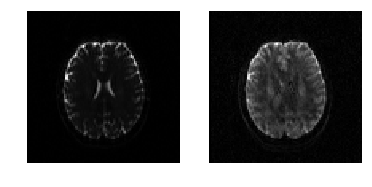

<Figure size 432x288 with 0 Axes>

In [3]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

Create a multi tensor with 2 fiber directions

In [4]:
evals = np.array([[0.0015, 0.0003, 0.0003],
                  [0.0015, 0.0003, 0.0003]])
directions = [(-30, 0), (30, 0)]
fractions = [50, 50]
signal, _ = multi_tensor(gtab, evals, 100, angles=directions,
                         fractions=fractions, snr=None)
sphere = get_sphere('symmetric724').subdivide(1)
odf_gt = multi_tensor_odf(sphere.vertices, evals, angles=directions,
                          fractions=fractions)

Perform the reconstructions with standard DSI and DSI with deconvolution

In [5]:
dsi_model = DiffusionSpectrumModel(gtab)
dsi_odf = dsi_model.fit(signal).odf(sphere)
dsid_model = DiffusionSpectrumDeconvModel(gtab)
dsid_odf = dsid_model.fit(signal).odf(sphere)

In [6]:
from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = True


ren = window.Renderer()

# concatenate data as 4D array
odfs = np.vstack((odf_gt, dsi_odf, dsid_odf))[:, None, None]
odf_actor = actor.odf_slicer(odfs, sphere=sphere,
                             scale=0.5, colormap='plasma')

odf_actor.display(y=0)
odf_actor.RotateX(90)
ren.add(odf_actor)
window.record(ren, out_path='dsid.png', size=(300, 300))
if interactive:
    window.show(ren)

/home/chrbecker/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
